# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import sys
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
sys.setrecursionlimit(10000)

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.ndimage.filters import uniform_filter1d
from scipy.optimize import curve_fit

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from sklearn.neighbors import KernelDensity
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

/tmp/ipykernel_3769725/3486609485.py:32: DeprecationWarning: Please import `uniform_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter1d


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'DejaVu Sans',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

# colors = cycle(mcolors.XKCD_COLORS.keys())

plt.rcParams['image.cmap'] = 'YlOrRd'
        

In [3]:
def get_cluster_trees_from_h5file(h5_file, cluster_similarity_threshold = .4, nskip = 10, part_min = 0):
    clusters = []
    with h5py.File(h5_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        for tg in time_grp_list:
            clust_grp = [cla.Cluster(h5_data = c) for c in tg.values()]
            clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
            clusters += [clust_grp]

    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    return trees

def get_lifetimes(branch_roots, min_time = 0, min_length = 0):
    lifetime_list = []
    for root in branch_roots:
        if root.time < min_time: # Skip if the root is too short
            continue
        l_branch = root.get_largest_branch()
        if len(l_branch) < min_length:
            continue
        lifetime_list += [l_branch[0].time-l_branch[-1].time]

    return lifetime_list

def get_time_of_events(branch_roots, min_time = 0, min_length = 0):
    eventime_list = []
    for root in branch_roots:
        if root.time < min_time: # Skip if the root is too short
            continue
        l_branch = root.get_largest_branch()
        if len(l_branch) < min_length:
            continue
        eventime_list += [l_branch[0].time]

    return eventime_list

def plot_branches(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue'):
    time_list = []
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .9  
    color_step = .8 / len(branch_roots)

    for i, root in enumerate(branch_roots):

        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)
        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=branch_color)
        if i > 0:
            _ = axarr.scatter(time_arr[0], size_arr_smooth[0],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=branch_color)

        if root.time == full_time_arr[-1]: 
            print('Skipping root')
            # Skip, this is not a real event
            continue
        time_list += [time_arr[0]-time_arr[-1]]
    return time_list

def plot_cluster_size(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue', alpha=1):
    time_arr_list = []
    size_arr_list = []
    type_list = []

    for i, root in enumerate(branch_roots):


        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time
        
        size_arr = size_arr[::-1]
        time_arr = time_arr[::-1]

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)
        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=color, alpha=alpha)

        if i > 0:
            _ = axarr.scatter(time_arr[-1], size_arr_smooth[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=color)
            type_list.append('M')
        elif size_arr[-1] < 50:
            type_list.append('D')
        else:
            type_list.append('L')

        size_arr_list.append(size_arr)
        time_arr_list.append(time_arr)

    return time_arr_list, size_arr_list, type_list

def plot_large_cluster_sizes(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue', alpha=1):
    time_arr_list = []
    size_arr_list = []

    for i, root in enumerate(branch_roots):


        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)[::-1]
        time_arr = time_arr[::-1]
        if i > 0 or root.time < 3600 or size_arr_smooth[-1] < 300:
            continue
            # _ = axarr.scatter(time_arr[-1], size_arr_smooth[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=color)

        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=color, alpha=alpha)

        size_arr_list.append(size_arr_smooth)
        time_arr_list.append(time_arr)

    return time_arr_list, size_arr_list

def plot_no_merge_cluster_sizes(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue', alpha=1):
    time_arr_list = []
    size_arr_list = []

    for i, root in enumerate(branch_roots):


        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)[::-1]
        time_arr = time_arr[::-1]
        if i > 0 :
            continue
            # _ = axarr.scatter(time_arr[-1], size_arr_smooth[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=color)

        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=color, alpha=alpha)

        size_arr_list.append(size_arr_smooth)
        time_arr_list.append(time_arr)

    return time_arr_list, size_arr_list

def plot_no_dissolve_cluster_sizes(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue', alpha=1):
    time_arr_list = []
    size_arr_list = []

    for i, root in enumerate(branch_roots):


        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)[::-1]
        time_arr = time_arr[::-1]
        if size_arr_smooth[-1] < 50:
            continue
            # _ = axarr.scatter(time_arr[-1], size_arr_smooth[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=color)

        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=color, alpha=alpha)

        size_arr_list.append(size_arr_smooth)
        time_arr_list.append(time_arr)

    return time_arr_list, size_arr_list

In [4]:

def plot_contact_kymo(fig, ax, time_arr, contact_kymo,
                      contact_type="", vmax=10, label_flag=True):
    y = np.arange(contact_kymo.shape[0] + 1)
    # Add extra time point
    x = np.append(time_arr, [time_arr[-1] + time_arr[2] - time_arr[1]])
    X, Y = np.meshgrid(x, y)
    c = ax.pcolorfast(X, Y, contact_kymo, vmax=vmax)
    divider = make_axes_locatable(ax)
    # Append axes to the right of ax, with 5% width of ax
    cax = divider.append_axes("top", size="5%", pad=0.05)

    cbar = fig.colorbar(c, cax=cax, label=r"Contact probability", orientation='horizontal', pad=0.1)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    # cbar.ax.set_position([.1, 1.02, .8, .02])

    ax.set_ylabel("Bead index")


# Figure 6

[[ 1.16226663e-02 -5.07444102e-05]
 [-5.07444102e-05  2.22824352e-07]]
a: 29.37, b: 0.35
R-squared: 0.99
dissolve prob: 0.59, merge prob: 0.41
Mean dissolve time: 428.16 +/- 0.04
Mean merge time: 206.17 +/- 0.04


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


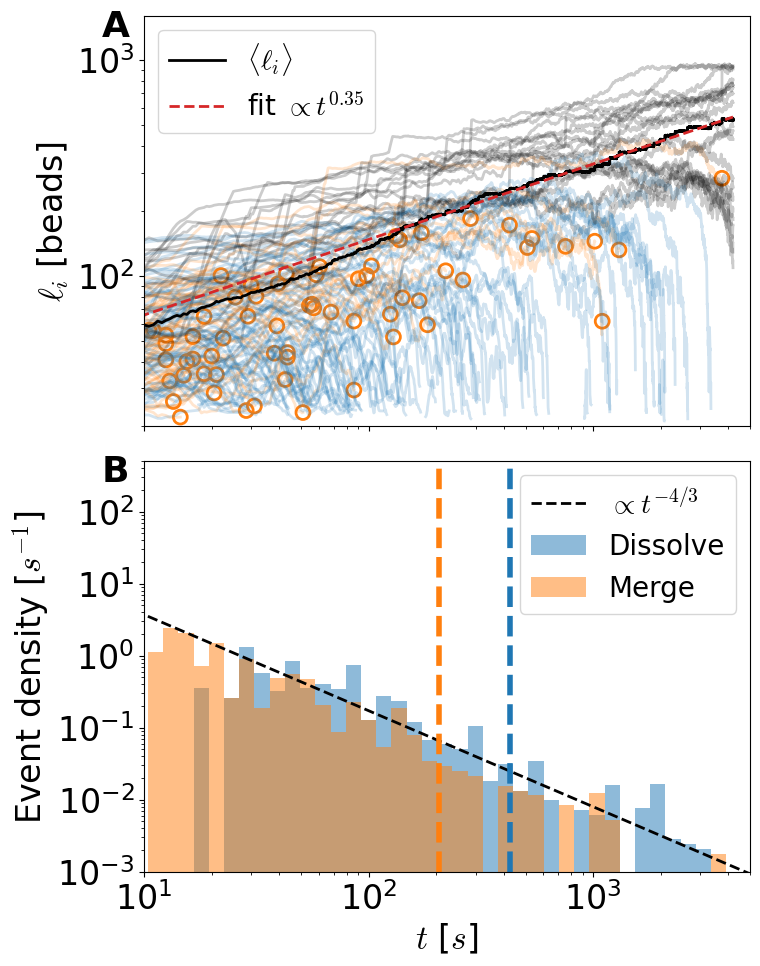

In [6]:
fig, axarr = plt.subplots(2,1, figsize=(8, 10), sharex=True)

with h5py.File('Figure6/cluster_size_5um_data.h5', 'r') as h5_data:
    sizes_list = []
    times_list = []
    dissolve_times = []
    merge_times = []
    for clust_dset in h5_data.values():
        time_arr = clust_dset[:, 0]
        size_arr = clust_dset[:, 1]
        smooth_size_arr = uniform_filter1d(size_arr, size=10)
        if clust_dset.attrs['type'] == 'M':
            _ = axarr[0].plot(time_arr, smooth_size_arr, color='tab:orange', alpha=.2)
            _ = axarr[0].scatter(time_arr[-1], smooth_size_arr[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor='tab:orange')
            merge_times.append(time_arr[-1])
        elif clust_dset.attrs['type'] == 'D':
            _ = axarr[0].plot(time_arr, smooth_size_arr, color='tab:blue', alpha=.2)
            dissolve_times.append(time_arr[-1])
        elif clust_dset.attrs['type'] == 'L':
            _ = axarr[0].plot(time_arr, smooth_size_arr, color='k', alpha=.2)
        times_list.append(time_arr)
        sizes_list.append(size_arr)

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)
_ = axarr[0].plot(time_arr_max, size_mean, color='k', linewidth=2, label=r'$\langle \ell_i \rangle$')

x = np.logspace(1, 4, 100)
# _ = axarr[0].plot(x, 10*np.power(x, 5/14), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')

def power_law(x, a, b):
    return a * np.power(x, b)

params, covar = curve_fit(power_law, time_arr_max, size_mean, p0=[1, 1/3])
a, b = params
print(covar)
print(f"a: {a:.2f}, b: {b:.2f}")
y_fit = power_law(time_arr_max, a, b)
_ = axarr[0].plot(time_arr_max, y_fit, linestyle='--', color='tab:red', linewidth=2, label=rf'fit $\propto t^{{{b:.2f}}}$')

_ = axarr[0].legend()
_ = axarr[0].set_xscale('log')
_ = axarr[0].set_yscale('log')
_ = axarr[0].set_ylabel(r"$\ell_i$ [beads]")
_ = axarr[0].set_ylim(20, 1600) 


bins_total = np.logspace(0, 4, 60)

# Calculate histograms with density=True
dissolve_hist, dissolve_bins = np.histogram(dissolve_times, bins=bins_total, density=True)
merge_hist, merge_bins = np.histogram(merge_times, bins=bins_total, density=True)

# Manually scale the heights by the bin widths and the total number of events
dissolve_hist_scaled = dissolve_hist * len(dissolve_times)
merge_hist_scaled = merge_hist * len(merge_times)

# Plot the histograms
_ = axarr[1].bar(dissolve_bins[:-1], dissolve_hist_scaled, width=np.diff(dissolve_bins), align='edge', label='Dissolve', alpha=.5)
_ = axarr[1].bar(merge_bins[:-1], merge_hist_scaled, width=np.diff(merge_bins), align='edge', label='Merge', alpha=.5)

_ = axarr[1].plot(bins_total, 80*np.power(bins_total, -4/3), linestyle='--', color='k', linewidth=2, label=r'$\propto t^{-4/3}$')

_ = axarr[1].axvline(np.mean(dissolve_times), color='tab:blue', linestyle='--', linewidth=4,
                    #    label=convert_e_to_x10n(rf'$\langle t_D \rangle = {np.mean(dissolve_times):.3g}\; s$'))
                       )
_ = axarr[1].axvline(np.mean(merge_times), color='tab:orange', linestyle='--', linewidth=4,
                    #    label=convert_e_to_x10n(rf'$\langle t_M \rangle = {np.mean(merge_times):.3g}\; s$'))
                       )
_ = axarr[1].legend()
_ = axarr[1].set_yscale('log')  
_ = axarr[1].set_ylabel('Event density [$s^{-1}$]')
_ = axarr[1].set_xlim(10, 5000)

_ = axarr[1].set_xlabel("$t$ [$s$]")
_ = axarr[1].set_ylim(1e-3,500) 
fig.tight_layout()
_ = axarr[0].text(-0.07, .95, "A", fontsize=26, transform=axarr[0].transAxes, fontweight='bold')
_ = axarr[1].text(-0.07, .95, "B", fontsize=26, transform=axarr[1].transAxes, fontweight='bold')


# Calculate residuals
residuals = size_mean - y_fit

# Calculate the total sum of squares
ss_tot = np.sum((size_mean - np.mean(size_mean))**2)

# Calculate the residual sum of squares
ss_res = np.sum(residuals**2)

# Calculate R-squared
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.2f}")

total = len(dissolve_times) + len(merge_times)
dissolve_prob = len(dissolve_times) / (len(dissolve_times) + len(merge_times))
merge_prob = 1 - dissolve_prob
# print(dissolve_prob, merge_prob)
print(f"dissolve prob: {dissolve_prob:.2f}, merge prob: {merge_prob:.2f}")

uncertainty = np.sqrt(dissolve_prob * merge_prob/total)
# print(uncertainty)
print(f"Mean dissolve time: {np.mean(dissolve_times):.2f} +/- {uncertainty:.2f}")
print(f"Mean merge time: {np.mean(merge_times):.2f} +/- {uncertainty:.2f}")


fig.savefig('Figure6/Fig6_distr.pdf', dpi=600, bbox_inches='tight')
fig.savefig('Figure6/Fig6_distr.eps', dpi=600, bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig6_distr.pdf", dpi=600, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig6_distr.eps", dpi=600, bbox_inches="tight")

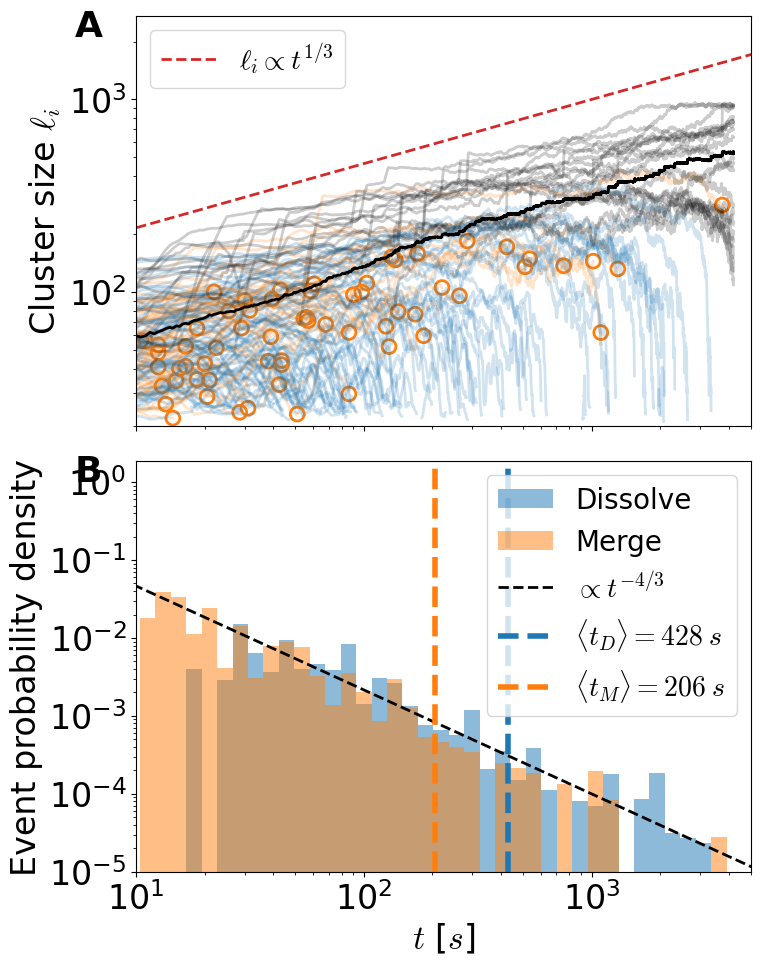

In [12]:
fig, axarr = plt.subplots(2,1, figsize=(8, 10), sharex=True)

with h5py.File('Figure6/cluster_size_5um_data.h5', 'r') as h5_data:
    sizes_list = []
    times_list = []
    dissolve_times = []
    merge_times = []
    for clust_dset in h5_data.values():
        time_arr = clust_dset[:, 0]
        size_arr = clust_dset[:, 1]
        smooth_size_arr = uniform_filter1d(size_arr, size=10)
        if clust_dset.attrs['type'] == 'M':
            _ = axarr[0].plot(time_arr, smooth_size_arr, color='tab:orange', alpha=.2)
            _ = axarr[0].scatter(time_arr[-1], smooth_size_arr[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor='tab:orange')
            merge_times.append(time_arr[-1])
        elif clust_dset.attrs['type'] == 'D':
            _ = axarr[0].plot(time_arr, smooth_size_arr, color='tab:blue', alpha=.2)
            dissolve_times.append(time_arr[-1])
        elif clust_dset.attrs['type'] == 'L':
            _ = axarr[0].plot(time_arr, smooth_size_arr, color='k', alpha=.2)
        times_list.append(time_arr)
        sizes_list.append(size_arr)

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)
_ = axarr[0].plot(time_arr_max, size_mean, color='k', linewidth=2)

x = np.logspace(1, 4, 100)
_ = axarr[0].plot(x, 100*np.power(x, 1/3), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')
_ = axarr[0].legend()
_ = axarr[0].set_xscale('log')
_ = axarr[0].set_yscale('log')
_ = axarr[0].set_ylabel(r"Cluster size $\ell_i$")
_ = axarr[0].set_ylim(20) 


bins_total = np.logspace(0, 4, 60)

_ = axarr[1].hist(dissolve_times, bins=bins_total, label='Dissolve', alpha=.5, density=True)
_ = axarr[1].hist(merge_times, bins=bins_total, label='Merge', alpha=.5, density=True)
_ = axarr[1].plot(bins_total, np.power(bins_total, -4/3), linestyle='--', color='k', linewidth=2, label=r'$\propto t^{-4/3}$')
_ = axarr[1].axvline(np.mean(dissolve_times), color='tab:blue', linestyle='--', linewidth=4,
                       label=convert_e_to_x10n(rf'$\langle t_D \rangle = {np.mean(dissolve_times):.3g}\; s$'))
_ = axarr[1].axvline(np.mean(merge_times), color='tab:orange', linestyle='--', linewidth=4,
                       label=convert_e_to_x10n(rf'$\langle t_M \rangle = {np.mean(merge_times):.3g}\; s$'))
_ = axarr[1].legend()
_ = axarr[1].set_yscale('log')  
_ = axarr[1].set_ylabel('Event probability density')
_ = axarr[1].set_xlim(10, 5000)

_ = axarr[1].set_xlabel("$t$ [$s$]")
_ = axarr[1].set_ylim(1e-5) 
fig.tight_layout()
_ = axarr[0].text(-0.1, .95, "A", fontsize=26, transform=axarr[0].transAxes, fontweight='bold')
_ = axarr[1].text(-0.1, .95, "B", fontsize=26, transform=axarr[1].transAxes, fontweight='bold')


# fig.savefig('Figure5/Fig5_distr.png', dpi=600, bbox_inches='tight')
# fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig5_distr.png", dpi=300, bbox_inches="tight")

# Supplement

(29, 84)
(30, 85)
(30, 85)


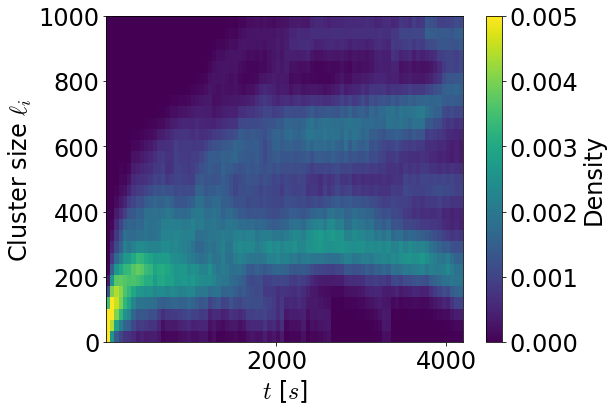

In [77]:

sim_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um/s2"
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'

with h5py.File(h5_clust_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]

new_time_arr = time_arr[1::100]

cluster_size_density_list = []

with h5py.File('Figure5/cluster_size_5um_data.h5', 'r') as h5_data:
    for t in new_time_arr:
        cluster_size_density_list.append([])
        csd = cluster_size_density_list[-1]
        for clust_dset in h5_data.values():
            # Check to see if the value t is in the first column of the dataset
            if t in clust_dset[:, 0]:
                csd.append(clust_dset[clust_dset[:, 0] == t, 1][0])

bins = np.linspace(0, 1000, 30)
heatmap = np.zeros((len(cluster_size_density_list), len(bins)-1))
for i, csd in enumerate(cluster_size_density_list):
    # Make a probabilty density histogram of the cluster sizes
    # hist, bin_edges = np.histogram(csd, bins=bins, density=True)
    bandwidth = 50 # You can adjust this value
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(np.reshape(csd, (-1, 1)))
    heatmap[i] = np.exp(kde.score_samples(bins[:-1,None]))

# Add another time point to the time array
new_time_arr = np.append(new_time_arr, new_time_arr[-1] + new_time_arr[2] - new_time_arr[1])

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
X, Y = np.meshgrid(new_time_arr, bins)
print(heatmap.T.shape)
print(X.shape)
print(Y.shape)
c = ax.pcolorfast(X, Y, heatmap.T, cmap='viridis', vmax=0.005)
fig.colorbar(c, ax=ax, label='Density')
# c = ax.pcolorfast(heatmap.T)
_ = ax.set_xlabel("$t$ [$s$]")
_ = ax.set_ylabel("Cluster size $\ell_i$")
    
    
fig.savefig("Figure6/supp_clust_size_distr_vs_time.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig6_supp_cluster_size_distr_vs_time.png", dpi=300, bbox_inches="tight") 


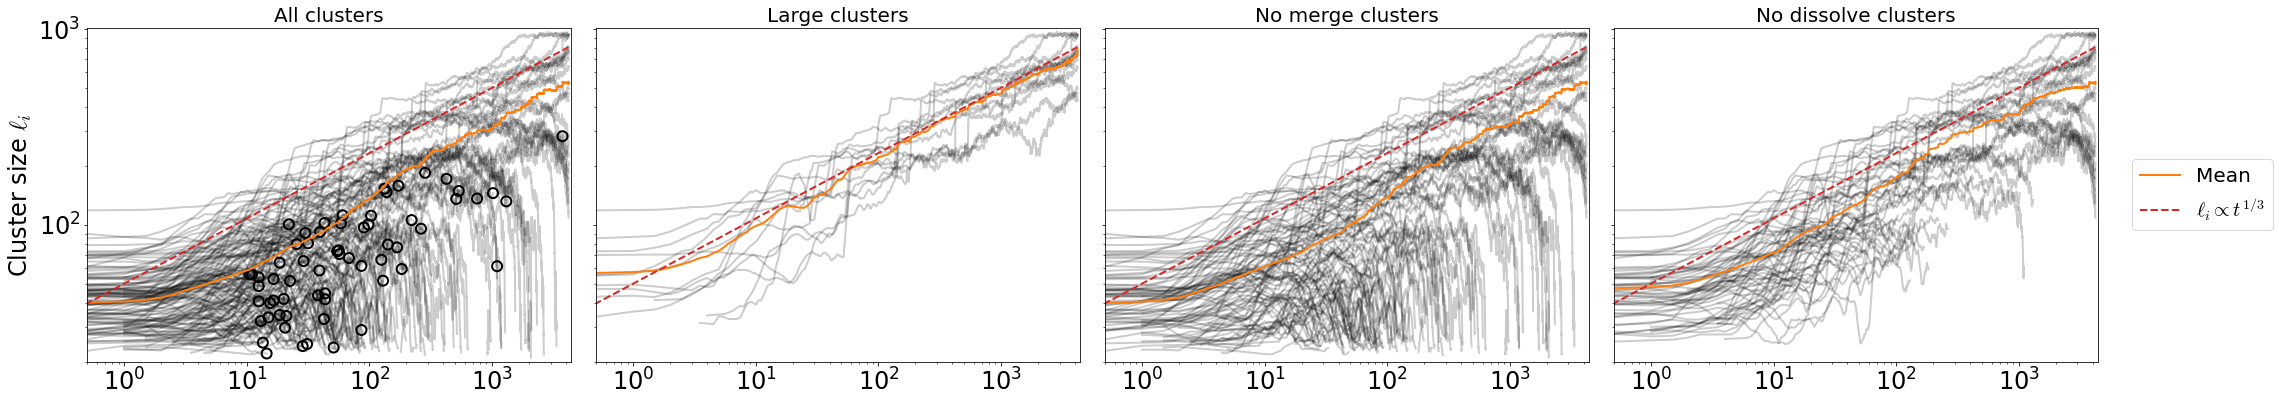

In [37]:
fig, axarr = plt.subplots(1,4, figsize=(32, 6), sharey=True, sharex=True)

# all clusters
times_list = []
sizes_list = []
for branch_roots, time_arr in zip(branch_root_5um_list, time_arr_5um_list):
    time_list, size_list = plot_cluster_size(axarr[0], time_arr, branch_roots, color='k', alpha=.2, window_size=10)
    times_list += time_list
    sizes_list += size_list

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)

_ = axarr[0].plot(time_arr_max, size_mean, linestyle='-', color='tab:orange', linewidth=2, label='Mean')

_ = axarr[0].plot(time_arr, 50*np.power(time_arr, 1/3), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')
_ = axarr[0].set_title("All clusters")



times_list = []
sizes_list = []
for branch_roots, time_arr in zip(branch_root_5um_list, time_arr_5um_list):
    time_list, size_list = plot_large_cluster_sizes(axarr[1], time_arr, branch_roots, color='k', alpha=.2, window_size=10 )
    times_list += time_list
    sizes_list += size_list

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)

_ = axarr[1].plot(time_arr_max, size_mean, linestyle='-', color='tab:orange', linewidth=2, label='Mean')

_ = axarr[1].plot(time_arr, 50*np.power(time_arr, 1/3), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')
_ = axarr[1].set_title("Large clusters")

times_list = []
sizes_list = []
for branch_roots, time_arr in zip(branch_root_5um_list, time_arr_5um_list):
    time_list, size_list = plot_no_merge_cluster_sizes(axarr[2], time_arr, branch_roots, color='k', alpha=.2, window_size=10 )
    times_list += time_list
    sizes_list += size_list

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)

_ = axarr[2].plot(time_arr_max, size_mean, linestyle='-', color='tab:orange', linewidth=2, label='Mean')

_ = axarr[2].plot(time_arr, 50*np.power(time_arr, 1/3), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')
_ = axarr[2].set_title("No merge clusters")

times_list = []
sizes_list = []
for branch_roots, time_arr in zip(branch_root_5um_list, time_arr_5um_list):
    time_list, size_list = plot_no_dissolve_cluster_sizes(axarr[3], time_arr, branch_roots, color='k', alpha=.2, window_size=10)
    times_list += time_list
    sizes_list += size_list

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)

_ = axarr[3].plot(time_arr_max, size_mean, linestyle='-', color='tab:orange', linewidth=2, label='Mean')

_ = axarr[3].plot(time_arr, 50*np.power(time_arr, 1/3), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')
_ = axarr[3].set_title("No dissolve clusters")

# _ = axarr.set_xlabel("$t$ [$s$]")
_ = axarr[0].set_ylim(20)
_ = axarr[0].set_xlim(.5)
_ = axarr[0].set_ylabel(r"Cluster size $\ell_i$")
_ = axarr[0].set_xscale('log')
_ = axarr[0].set_yscale('log')
_ = axarr[-1].legend(loc='center left', bbox_to_anchor=(1.05, .5))


fig.tight_layout()


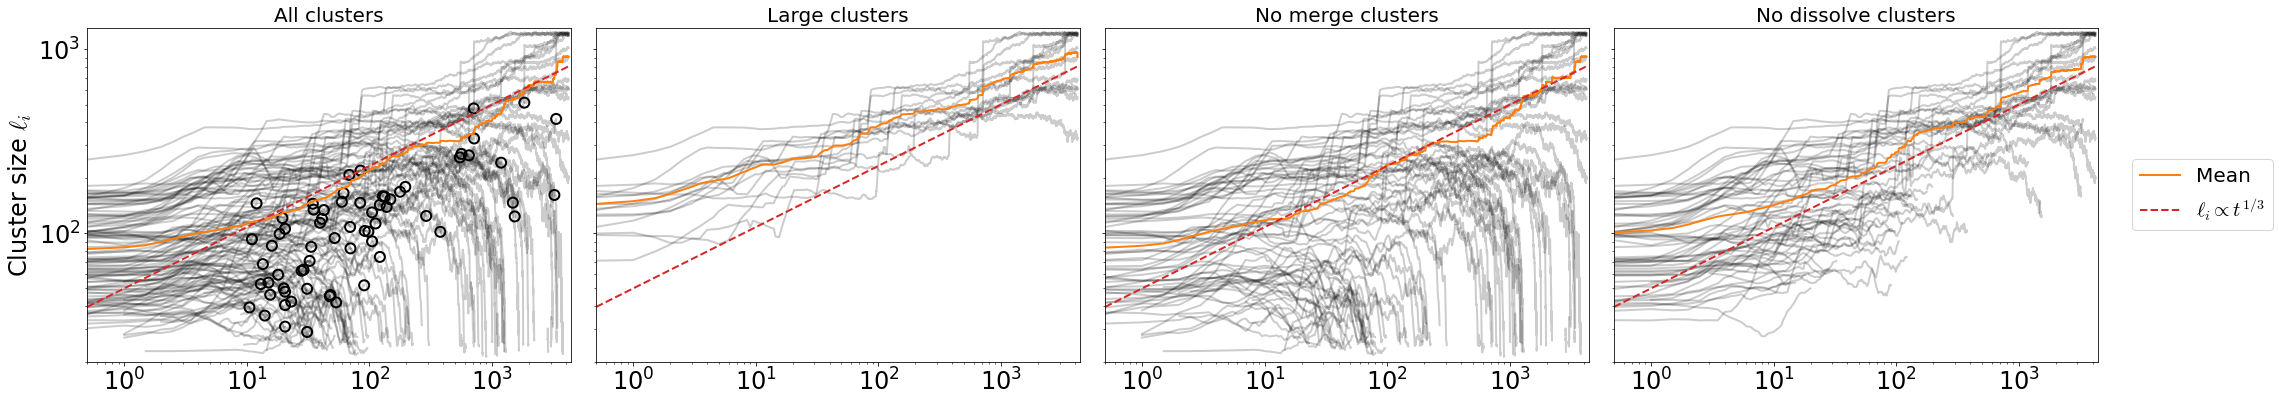

In [46]:
fig, axarr = plt.subplots(1,4, figsize=(32, 6), sharey=True, sharex=True)

# all clusters
times_list = []
sizes_list = []
for branch_roots, time_arr in zip(branch_root_3um_list, time_arr_3um_list):
    time_list, size_list = plot_cluster_size(axarr[0], time_arr, branch_roots, color='k', alpha=.2)
    times_list += time_list
    sizes_list += size_list

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)

_ = axarr[0].plot(time_arr_max, size_mean, linestyle='-', color='tab:orange', linewidth=2, label='Mean')

_ = axarr[0].plot(time_arr, 50*np.power(time_arr, 1/3), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')
_ = axarr[0].set_title("All clusters")

times_list = []
sizes_list = []
for branch_roots, time_arr in zip(branch_root_list, time_arr_list):
    time_list, size_list = plot_large_cluster_sizes(axarr[1], time_arr, branch_roots, color='k', alpha=.2)
    times_list += time_list
    sizes_list += size_list

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)

_ = axarr[1].plot(time_arr_max, size_mean, linestyle='-', color='tab:orange', linewidth=2, label='Mean')

_ = axarr[1].plot(time_arr, 50*np.power(time_arr, 1/3), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')
_ = axarr[1].set_title("Large clusters")

times_list = []
sizes_list = []
for branch_roots, time_arr in zip(branch_root_list, time_arr_list):
    time_list, size_list = plot_no_merge_cluster_sizes(axarr[2], time_arr, branch_roots, color='k', alpha=.2)
    times_list += time_list
    sizes_list += size_list

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)

_ = axarr[2].plot(time_arr_max, size_mean, linestyle='-', color='tab:orange', linewidth=2, label='Mean')

_ = axarr[2].plot(time_arr, 50*np.power(time_arr, 1/3), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')
_ = axarr[2].set_title("No merge clusters")

times_list = []
sizes_list = []
for branch_roots, time_arr in zip(branch_root_list, time_arr_list):
    time_list, size_list = plot_no_dissolve_cluster_sizes(axarr[3], time_arr, branch_roots, color='k', alpha=.2)
    times_list += time_list
    sizes_list += size_list

size_mean = mean_of_arrays(sizes_list)
time_arr_max = max(times_list, key=lambda x: x.size)

_ = axarr[3].plot(time_arr_max, size_mean, linestyle='-', color='tab:orange', linewidth=2, label='Mean')

_ = axarr[3].plot(time_arr, 50*np.power(time_arr, 1/3), linestyle='--', color='tab:red', linewidth=2, label=r'$\ell_i \propto t^{1/3}$')
_ = axarr[3].set_title("No dissolve clusters")

# _ = axarr.set_xlabel("$t$ [$s$]")
_ = axarr[0].set_ylim(20)
_ = axarr[0].set_xlim(.5)
_ = axarr[0].set_ylabel(r"Cluster size $\ell_i$")
_ = axarr[0].set_xscale('log')
_ = axarr[0].set_yscale('log')
_ = axarr[-1].legend(loc='center left', bbox_to_anchor=(1.05, .5))


fig.tight_layout()


In [ ]:
# Total events
end_time = 2400
min_time = 0
min_length = 5

data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/"
sim_path = data_path / "simulations/Ke100_Pin5.0um/"

merge_lifetime_total_list = []
dissolve_lifetime_total_list = []
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time and tree.clusters[0].time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_total_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_total_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)

min_time = 100
merge_lifetime_later_list = []
dissolve_lifetime_later_list = []
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time and tree.clusters[0].time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_later_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_later_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)


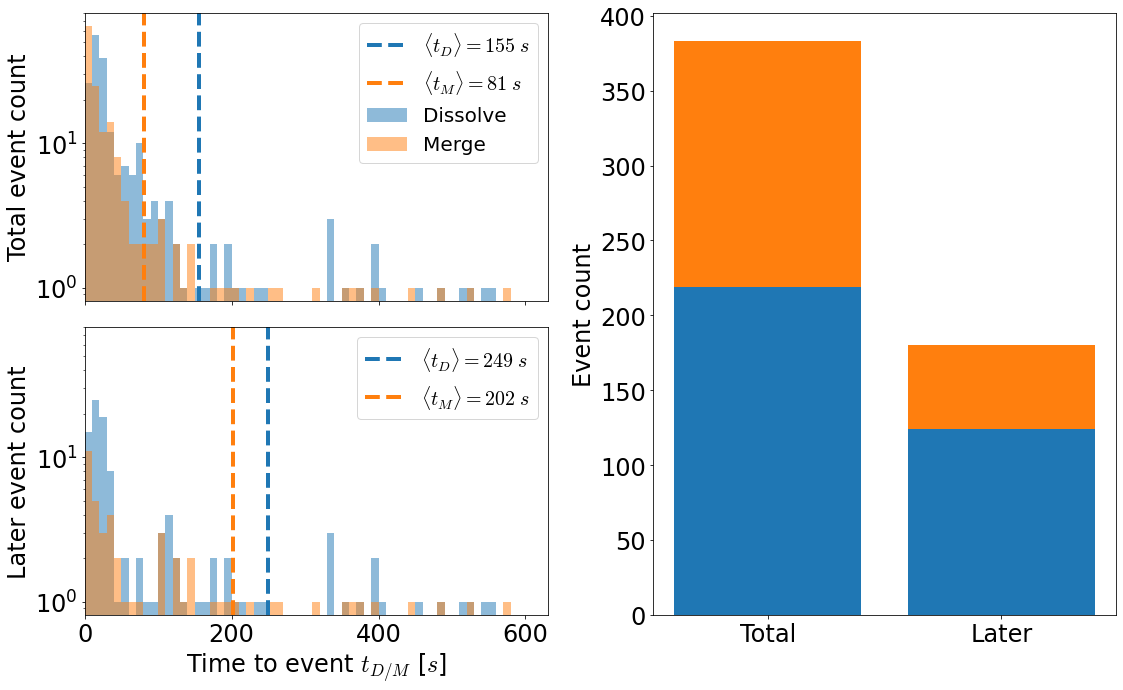

In [ ]:

gs = gridspec.GridSpec(2, 6)

fig = plt.figure(figsize=(16, 10))
axarr = [fig.add_subplot(gs[0, 0:3])]

fig.subplots_adjust(hspace=0.1, wspace=0.7)
axarr += [fig.add_subplot(gs[1, :3], sharex=axarr[0], sharey=axarr[0]), fig.add_subplot(gs[:, 3:])]

_ = axarr[0].hist(dissolve_lifetime_total_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr[0].hist(merge_lifetime_total_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr[0].axvline(np.mean(dissolve_lifetime_total_list), color='tab:blue', linestyle='--', linewidth=4,
                        label=convert_e_to_x10n(rf'$\langle t_D \rangle = {np.mean(dissolve_lifetime_total_list):.3g}\; s$'))
_ = axarr[0].axvline(np.mean(merge_lifetime_total_list), color='tab:orange', linestyle='--', linewidth=4,
                        label=convert_e_to_x10n(rf'$\langle t_M \rangle = {np.mean(merge_lifetime_total_list):.3g}\; s$'))
_ = axarr[0].legend()
_ = axarr[0].set_yscale('log')  
_ = axarr[0].set_ylabel('Total event count')
_ = axarr[0].set_xlim(0)


_ = axarr[1].set_ylabel('Later event count')
_ = axarr[1].hist(dissolve_lifetime_later_list, bins=60, alpha=.5, range=(0, 600))
_ = axarr[1].hist(merge_lifetime_later_list, bins=60, alpha=.5, range=(0, 600))
_ = axarr[1].axvline(np.mean(dissolve_lifetime_later_list), color='tab:blue', linestyle='--', linewidth=4,
                        label=convert_e_to_x10n(rf'$\langle t_D \rangle = {np.mean(dissolve_lifetime_later_list):.3g}\; s$'))
_ = axarr[1].axvline(np.mean(merge_lifetime_later_list), color='tab:orange', linestyle='--', linewidth=4,
                        label=convert_e_to_x10n(rf'$\langle t_M \rangle = {np.mean(merge_lifetime_later_list):.3g}\; s$'))
_ = axarr[1].set_xlabel('Time to event $t_{D/M}$ [$s$]')
_ = axarr[1].legend()

_ = axarr[2].bar(['Total', 'Later'], [np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:blue', 'tab:blue'])
_ = axarr[2].bar(['Total', 'Later'], [np.size(merge_lifetime_total_list), np.size(merge_lifetime_later_list)], bottom=[np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:orange', 'tab:orange'])
_ = axarr[2].set_ylabel('Event count')

_ = plt.setp(axarr[0].get_xticklabels(), visible=False)
# axarr[0].label_outer()
fig.tight_layout()

fig.savefig('Figure3/lifetime_histograms.png', dpi=600, bbox_inches='tight')
            

# Collect data

In [ ]:
# Takes about 3 minutes to run
sim_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um"

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40


# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

branch_root_5um_list = []
size_5um_list = []
time_5um_list = []
type_5um_list = []

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for h5_clust_file in sim_path.glob('s*/analysis/cluster_analysis.h5'):
    print(h5_clust_file)

    with h5py.File(h5_clust_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree] if len(tree.clusters) > tree_length else []

    trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)


    for tree in trees:
        branch_roots = tree.get_branch_roots()
        branch_root_5um_list.append(branch_roots)

        time_list, size_list, type_list = plot_cluster_size(axarr, time_arr, branch_roots, color='k', alpha=.2)
        time_5um_list += time_list
        size_5um_list += size_list
        type_5um_list += type_list

_ = axarr.set_xlabel("$t$ [$s$]")
_ = axarr.set_ylabel(r"Cluster size $\ell_i$")
_ = axarr.set_ylim(20)

print(len(time_5um_list))
print(len(size_5um_list))
print(len(type_5um_list))
# Make hdf5 file with data for each time and cluster
with h5py.File('Figure6/cluster_size_5um_data.h5', 'w') as h5_data:
    for i, (time_arr, size_arr, t) in enumerate(zip(time_5um_list, size_5um_list, type_5um_list)):
        dset = h5_data.create_dataset(f'clust_{i}', data=np.vstack([time_arr, size_arr]).T)
        dset.attrs['type'] = t

fig.tight_layout()


/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s11/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s12/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s5/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s9/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s8/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


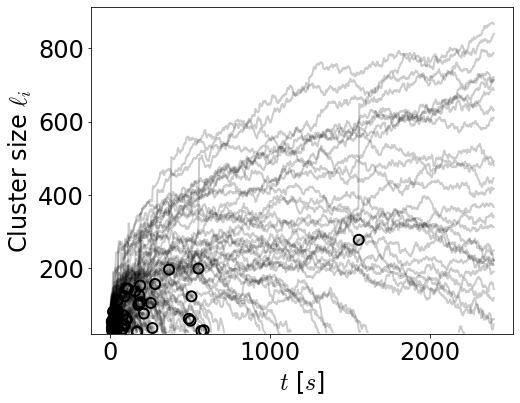

In [6]:
# Takes about 3 minutes to run
sim_path = ceph_path / "DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um"

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40


# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

branch_root_5um_list = []
size_5um_list = []
time_5um_list = []
type_5um_list = []

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for h5_clust_file in sim_path.glob('s*/analysis/cluster_analysis.h5'):
    print(h5_clust_file)

    with h5py.File(h5_clust_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree] if len(tree.clusters) > tree_length else []

    trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)


    for tree in trees:
        branch_roots = tree.get_branch_roots()
        branch_root_5um_list.append(branch_roots)

        time_list, size_list, type_list = plot_cluster_size(axarr, time_arr, branch_roots, color='k', alpha=.2)
        time_5um_list += time_list
        size_5um_list += size_list
        type_5um_list += type_list

print(len(time_5um_list))
print(len(size_5um_list))
print(len(type_5um_list))
# Make hdf5 file with data for each time and cluster
with h5py.File('Figure6/cluster_size_5um_kod3_data.h5', 'w') as h5_data:
    for i, (time_arr, size_arr, t) in enumerate(zip(time_5um_list, size_5um_list, type_5um_list)):
        dset = h5_data.create_dataset(f'clust_{i}', data=np.vstack([time_arr, size_arr]).T)
        dset.attrs['type'] = t

_ = axarr.set_xlabel("$t$ [$s$]")
_ = axarr.set_ylabel(r"Cluster size $\ell_i$")
_ = axarr.set_ylim(20)

fig.tight_layout()



In [ ]:
# Takes about 3 minutes to run
sim_path = ceph_path / "DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod300_Pin5.0um"

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40


# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

branch_root_5um_list = []
size_5um_list = []
time_5um_list = []
type_5um_list = []

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for h5_clust_file in sim_path.glob('s*/analysis/cluster_analysis.h5'):
    print(h5_clust_file)

    with h5py.File(h5_clust_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree] if len(tree.clusters) > tree_length else []

    trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)


    for tree in trees:
        branch_roots = tree.get_branch_roots()
        branch_root_5um_list.append(branch_roots)

        time_list, size_list, type_list = plot_cluster_size(axarr, time_arr, branch_roots, color='k', alpha=.2)
        time_5um_list += time_list
        size_5um_list += size_list
        type_5um_list += type_list

print(len(time_5um_list))
print(len(size_5um_list))
print(len(type_5um_list))
# Make hdf5 file with data for each time and cluster
with h5py.File('Figure6/cluster_size_5um_kod300_data.h5', 'w') as h5_data:
    for i, (time_arr, size_arr, t) in enumerate(zip(time_5um_list, size_5um_list, type_5um_list)):
        dset = h5_data.create_dataset(f'clust_{i}', data=np.vstack([time_arr, size_arr]).T)
        dset.attrs['type'] = t

_ = axarr.set_xlabel("$t$ [$s$]")
_ = axarr.set_ylabel(r"Cluster size $\ell_i$")
_ = axarr.set_ylim(20)

fig.tight_layout()



/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s11/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s12/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s5/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s9/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin5.0um/s8/analysis/cluster_analysis.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/